#### Aug. 10, 2018 320pm

In [1]:
import numpy   as np
import pandas  as pd

import pickle
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


---

#### Function Definitions

In [2]:
def time_Now():
    import datetime
    import pytz
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return (pst_now)

In [3]:
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label',  fontsize=14)
    plt.xlabel('Predicted label',  fontsize=14)

In [4]:
def plot_model_ROC(model, X_df, y_true, figTitle=None, printMetrics=False, figName=None):
    '''
        Function will plot the Model's ROC curve with several options:
        - alter the fig TITLE
        - APPEND model metrics to the figure
        - SAVE figure as a *.png and a*.pdf file
        
        Function will execute with only 3 of the 6 parameters
        - sklearn model that can give a predict_proba
        - X_df to apply the predict_proba
        - y_true the true values to compute TPR and FPR (T/F positive rates)
    '''
    
    pred = model.predict(X_df)
    y_score = model.predict_proba(X_df)[:,1]

    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, 'o--')
    plt.plot(np.linspace(0,1), np.linspace(0,1), 'k--')
    plt.ylabel("True Positive Rate",  fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=14);
    plt.text(.6, .1, "AUC score: {0:.4f}".format( roc_auc_score(y_test, y_score) ), fontsize=14);
    
    if figTitle:
        plt.title(figTitle)
    else:
        plt.title(str(model))
        
    if printMetrics:
        plt.text(.6, .15, "Accuracy score: {0:.4f}".format( accuracy_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .2, "Precision score: {0:.4f}".format( precision_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .25, "Recall score: {0:.4f}".format( recall_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .3, "F1 score: {0:.4f}".format( f1_score(y_true, pred) ), fontsize=14);

    if figName:
        print("saving..." + figName)
        plt.gcf()
        plt.savefig(figName + '.png')
        plt.savefig(figName + '.pdf')

In [5]:
def show_most_informative_features(vectorizer, clf, n=20):
    
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [6]:
def topWords(clf_model_nb, vectorFts, numFtrs=50):

    
    # Empirical log probability of features x_i, given a class y; P(x_i|y).

    ftr_logProb = clf_model_nb.feature_log_prob_
    ftr_logProb.shape

    # Smoothed empirical log probability for each class.
    class_logProb = clf_model_nb.class_log_prior_


    posterior_ratios = (ftr_logProb[1,:] - ftr_logProb[0,:] + class_logProb[1] - class_logProb[0])

    inds = np.argsort(posterior_ratios)[-1:-200:-1]

    # posterior_ratios[inds]

    print(np.array(vectorFts)[inds])

---
### Modified: 

In [7]:
print("Last modified on: ", time_Now())

Last modified on:  2018-08-12 13:58:15.178696-07:00


---

### Large Pickled Dataset



In [8]:
%%time
df = pd.read_pickle("newRev_VegCols_US.pkl")

CPU times: user 748 ms, sys: 540 ms, total: 1.29 s
Wall time: 1.29 s


In [9]:
%%time
X_df = df.drop(['vegFriendly', 'Vegan', 'Vegetarian'], axis=1)
y_df = df['vegFriendly']

CPU times: user 100 ms, sys: 20 ms, total: 120 ms
Wall time: 122 ms


In [10]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923002 entries, 0 to 923001
Data columns (total 17 columns):
business_id    923002 non-null object
name           923002 non-null object
review_id      923002 non-null object
stars          923002 non-null int64
date           923002 non-null datetime64[ns]
text           923002 non-null object
useful         923002 non-null int64
funny          923002 non-null int64
cool           923002 non-null int64
city           923002 non-null object
state          923002 non-null object
Thai           923002 non-null float64
Italian        923002 non-null float64
Indian         923002 non-null float64
Chinese        923002 non-null float64
Mexican        923002 non-null float64
Text_length    923002 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(5), object(6)
memory usage: 119.7+ MB


In [11]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: re.sub(r'(\d+)', '', rev) )

CPU times: user 15.1 s, sys: 132 ms, total: 15.2 s
Wall time: 15.2 s


In [12]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: rev.replace('_', '') )

CPU times: user 660 ms, sys: 0 ns, total: 660 ms
Wall time: 662 ms


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [14]:
print( X_train.shape, X_test.shape)

(646101, 17) (276901, 17)


---

### Manipulate data sets

In [15]:
stopWords = list(stopwords.words('english'))
stopWords.extend(['good', 'excellent', 'best', 'like', 'place', 'really', 'ordered', 'amazing', 'fantastic', 'am', 'pm'])
# 189
stopWords.extend(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuggggggggggggggggggg', 'aaaaaaah'])
stopWords.extend(['aaaaaaamazing', 'aaaaaaand', 'aaaaaamazing', 'aaaaahhhh', 'aaaaahhhhhhmazing', 'aaaaahhhhmaaazeballs', 'aaaaamazing', 'aaaaand'])
stopWords.extend(['aaaack', 'aaaamazing', 'aaaammmazziiigggg', 'aaaand', 'aaaarrgh', 'aaah', 'aaahh'])
stopWords.extend(['aaahhhh', 'aaahhhhh', 'aaahhhhmmmaaazzziiiinnnnggg'])
stopWords.extend(['aaammaziiiing', 'aaand', 'aab', 'aaboud', 'aac', 'aachi', 'aadd', 'aaggh', 'aagh', 'aah', 'aahan', 'aahc', 'aahhh'])
stopWords.extend(['aahhhh', 'aahhhhhh', 'aahhhhhhmazing', 'aahhhhhmazing', 'aahhhhmazing', 'aahing', 'aahran'])
# 234
stopWords.extend(['aaaaaaaaaa', 'aaaaaaaaaaaaaand', 'aaaaaaaaaaaaaauthentic', 'aaaaaaaaaaaaaawwwwwwwwwwwwwwwwwwwwww', 'aaaaaaaaaaack', 'aaaaaaaaaaah', 'aaaaaaaaaand', 'aaaaaaaaargh', 'aaaaaaaack', 'aaaaaaaahhhhhhhhh', 'aaaaaaaamazing', 'aaaaaaaand', 'aaaaaaall', 'aaaaaaamaaaaazing', 'aaaaaaammmmazing', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhmazing', 'aaaaaand', 'aaaaaannnddd', 'aaaaaannnndddd', 'aaaaagh', 'aaaaah', 'aaaaahhhhmazing', 'aaaaamaaazing', 'aaaaammmaazzzinnngg', 'aaaaarrrggghh', 'aaaaawful', 'aaaaay', 'aaaagh', 'aaaah', 'aaaahh', 'aaaahhh', 'aaaahhhh', 'aaaahhhhhhh', 'aaaahmazzzing', 'aaaajúa', 'aaaall', 'aaaalllllllll', 'aaaallright', 'aaaammaaazzinnnggg', 'aaaammazzing', 'aaaammmaaaaazzzziiiinnnngggg', 'aaaammmaaazing', 'aaaammmmmmazing', 'aaaamzing', 'aaaandd', 'aaaanddd', 'aaaannnd', 'aaaannnnd', 'aaaanyway', 'aaaawesoooome', 'aaaawwwesome', 'aaaawwwww', 'aaagggrrrrrrrhhhhh', 'aaahahaa', 'aaahhh', 'aaahhhhhhh', 'aaahhhs', 'aaahing', 'aaahmaaaazing', 'aaahmazing', 'aaahs', 'aaaiiiiight', 'aaall', 'aaallll', 'aaalways', 'aaamaazing', 'aaamazing', 'aaammaaazzziinnnngggg', 'aaammazing', 'aaammmazing', 'aaammmazinggggg', 'aaammmmaaazzziinnggg', 'aaannd', 'aaanndd', 'aaannndd', 'aaannnnd', 'aaanyway', 'aaare', 'aaawwee', 'aaawww', 'aaawwwwsome', 'aaay', 'aacross', 'aadbcc', 'aadorbsssssss', 'aagain', 'aahaan', 'aahed', 'aahh', 'aahs', 'aaid', 'aaiight', 'aaiiight', 'aaim', 'aaka', 'aaked', 'aaliyah', 'aall'])
stopWords.extend(['aaaaaaaaaaaaahhhhhhh', 'aaaaaaaaaah', 'aaaaaaaahhhhmazing', 'aaaaaaaawesooooooooooooome', 'aaaaaaggghhh', 'aaaaaah', 'aaaaaawesome', 'aaaaahhh', 'aaaaahhhhhh', 'aaaahhhhhhs', 'aaaajua', 'aaaalmost', 'aaaamazzzzing', 'aaaammaaazzziiingggg', 'aaaarreeeee', 'aaagh', 'aaahed', 'aaahhhmaaaazing', 'aaahhhmazing', 'aaammaazzing', 'aaarghhh', 'aahaha', 'aahhhhhaaaahhhhh'])
# 357 

In [16]:
vectorizer = TfidfVectorizer(stop_words=stopWords, strip_accents = 'ascii' )

#### Vectorize Review Text

In [17]:
%%time
X_train_term  = vectorizer.fit_transform(X_train['text'])

CPU times: user 43.8 s, sys: 624 ms, total: 44.4 s
Wall time: 44.4 s


In [18]:
X_train_term.shape

(646101, 137382)

In [19]:
ftrs = vectorizer.get_feature_names()
ftrs

['14',
 '34',
 'aaaaaaaaaaaand',
 'aaaamaaazing',
 'aaaasssighyeeeeeeeee',
 'aaammmaziinng',
 'aalad',
 'aallll',
 'aalmon',
 'aalo',
 'aaloo',
 'aalways',
 'aam',
 'aamaaazing',
 'aamaazingly',
 'aamco',
 'aammaazzing',
 'aammmmazing',
 'aamrass',
 'aamzing',
 'aan',
 'aand',
 'aanddddd',
 'aangekleed',
 'aangenaam',
 'aanji',
 'aanold',
 'aanrader',
 'aany',
 'aaocf',
 'aaovdvrdbvfzjbtweela',
 'aapam',
 'aapex',
 'aaqcgwvwa',
 'aardvark',
 'aare',
 'aargh',
 'aarika',
 'aaron',
 'aaronlauxdesign',
 'aarp',
 'aas',
 'aasda',
 'aash',
 'aat',
 'aate',
 'aatqea',
 'aau',
 'aavailable',
 'aaws',
 'aawsome',
 'aawwwesooomme',
 'aay',
 'aayesha',
 'ab',
 'ababa',
 'abacc',
 'aback',
 'abacus',
 'abadaba',
 'abadado',
 'abado',
 'abadoba',
 'abados',
 'abajo',
 'abale',
 'abali',
 'abalone',
 'abalones',
 'abalonushrooms',
 'aban',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abandonned',
 'abandons',
 'abao',
 'abaot',
 'abar',
 'abarca',
 'abarrotes',
 'abate',
 'abated',
 '

In [20]:
len(vectorizer.get_stop_words())

357

---

#### Mutlinomial NB - Train

In [21]:
%%time
M_NB_model = MultinomialNB()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [22]:
%%time
M_NB_model.fit(X_train_term, y_train)

CPU times: user 308 ms, sys: 8 ms, total: 316 ms
Wall time: 314 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

---

#### Multinomial NB - Test

In [23]:
%%time
X_test_term = vectorizer.transform(X_test['text'])

CPU times: user 19.3 s, sys: 144 ms, total: 19.4 s
Wall time: 19.4 s


In [24]:
X_test_term.shape

(276901, 137382)

In [25]:
%%time
pred = M_NB_model.predict(X_test_term)

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 80.1 ms


In [26]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.83      0.99      0.91    220194
        1.0       0.90      0.23      0.36     56707

avg / total       0.85      0.84      0.79    276901



In [27]:
accuracy_score(y_test, pred)

0.8364000130010365

In [28]:
precision_score(y_test, pred)

0.9017894885162745

In [29]:
recall_score(y_test, pred)

0.22572169220731125

In [30]:
f1_score(y_test, pred)

0.36106683967786063

Confusion matrix, without normalization


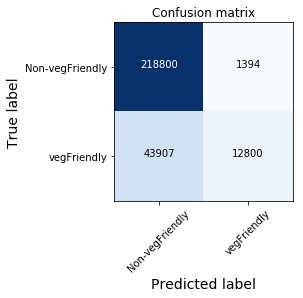

In [31]:
lbls = ['Non-vegFriendly', 'vegFriendly']
cm = confusion_matrix(y_test, pred)

plot_confusion_matrix(cm,lbls)

saving...MNB_357StWds_full


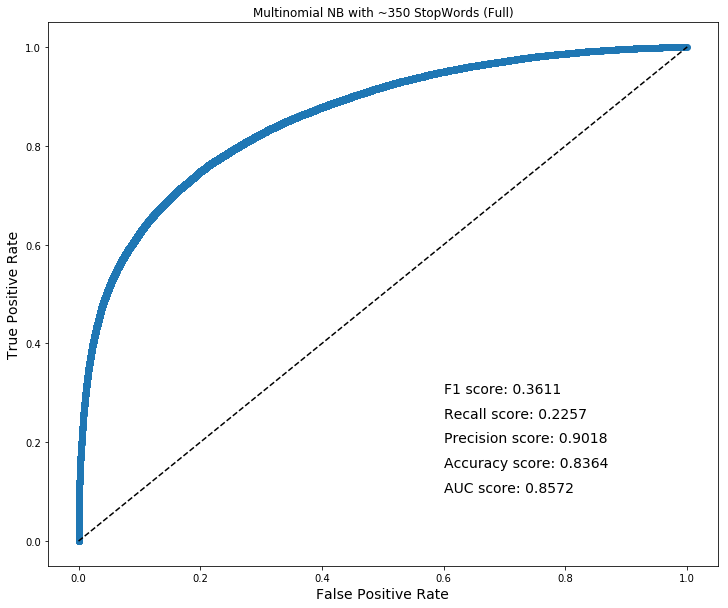

In [35]:
fTitle = 'Multinomial NB with ~350 StopWords (Full)'
mMetrics = True
fName = 'MNB_357StWds_full'
plot_model_ROC(M_NB_model, X_test_term, y_test, fTitle, mMetrics) #, fName)

---

### Log odds of priors

In [36]:
show_most_informative_features(vectorizer, M_NB_model, 20)

	-13.6716	14             		-5.0337	food           
	-13.6716	aaaaaaaaaaaand 		-5.2836	great          
	-13.6716	aaaamaaazing   		-5.5457	vegan          
	-13.6716	aaammmaziinng  		-5.6154	service        
	-13.6716	aalad          		-5.7837	love           
	-13.6716	aalmon         		-5.8029	delicious      
	-13.6716	aalo           		-5.8362	back           
	-13.6716	aalways        		-5.8707	time           
	-13.6716	aamaaazing     		-5.8789	chicken        
	-13.6716	aamaazingly    		-5.8931	go             
	-13.6716	aamco          		-5.9512	one            
	-13.6716	aammaazzing    		-6.0050	thai           
	-13.6716	aamzing        		-6.0098	get            
	-13.6716	aanddddd       		-6.0220	restaurant     
	-13.6716	aangekleed     		-6.0235	try            
	-13.6716	aangenaam      		-6.0504	friendly       
	-13.6716	aanji          		-6.0522	also           
	-13.6716	aanold         		-6.0586	menu           
	-13.6716	aanrader       		-6.0688	would          
	-13.6716	aany           		-6.1

---
### Ratio of posteriors for both classes

In [37]:
topWords(M_NB_model, ftrs, 50)

['injera' 'wac' 'vegenation' 'ethiopian' 'tsoynami' 'lalibela' 'wellness'
 'nami' 'tsoynamis' 'choolaah' 'hussong' 'vegeway' 'yc' 'dotty' 'ycs'
 'tlt' 'acai' 'brimstone' 'fern' 'soynami' 'brizza' 'grabbagreen'
 'olivier' 'capastrami' 'chopt' 'hussongs' 'zenith' 'turban' 'aladdin'
 'lgbtq' 'chakra' 'lunasagna' 'udupi' 'panevino' 'gomen' 'gandhi' 'abay'
 'chima' 'violette' 'tfk' 'pastoli' 'cheba' 'pasties' 'condesa' 'shwarma'
 'thailicious' 'jovany' 'yayo' 'pitaya' 'tahini' 'eatt' 'hemp' 'tibs'
 'grabba' 'bobbie' 'zizi' 'kombucha' 'genghis' 'mijana' 'santisima'
 'pitza' 'buraka' 'greene' 'luxe' 'bronze' 'quiessence' 'lyfe' 'apteka'
 'aladdins' 'doan' 'rani' 'cinnaholic' 'graz' 'ike' 'yupha' 'weil'
 'quesas' 'soynamis' 'misir' 'bizness' 'choolah' 'panacea' 'shawarma'
 'pinkys' 'schwarma' 'alicha' 'dumplinghaus' 'misoya' 'doro' 'qwik'
 'nandini' 'souper' 'dropout' 'rawco' 'ruchi' 'freshii' 'ethiopia' 'ipho'
 'franktuary' 'kyklos' 'jungles' 'mika' 'bragg' 'mvpita' 'yardhouse'
 'zoes' 'nakam